In [83]:
from os import listdir
import csv
import os
import numpy as np
import pandas as pd
from scipy.misc import imresize, imread, imshow
import skimage
from skimage import io
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt

In [179]:
def load_img(img_filename):
    """
    Load image from the filename. Default is to load in color if
    possible.
    Args:
        img_name (string): string of the image name, relative to
            the image directory.
    Returns:
        np array of float32: an image as a numpy array of float32
    """
    img = skimage.img_as_float(imread(
        img_filename,mode='RGB')).astype(np.float32)
    if img.ndim == 2:
        img = img[:, :, np.newaxis]
    elif img.shape[2] == 4:
        img = img[:, :, :3]
    return img

In [181]:
class DictIterator():
    '''
    Class for iterating over a pandas data frame with filenames and addresses

    TODO
    add comments
    '''
    def __init__(self,csv_location = None,
                 batch_size=32,
                 shuffle=False,
                 target_size=(64,64)):
        
        if csv_location is not None:
            self.df = pd.read_csv(csv_location)
        self.N = self.df.shape[0]
        print(self.N)
        self.batch_size = batch_size
        self.total_batches_seen = 0
        self.index_gen = self._idx_gen(self.N,batch_size,shuffle)
        self.target_size = target_size

    def _idx_gen(self,N,batch_size=32,shuffle=False):
        batch_index = 0
        while 1:
            if batch_index == 0:
                index_array = np.arange(N)
                if shuffle:
                    index_array = np.random.permutation(N)
            current_index = (batch_index * batch_size) % N
            if N >= current_index + batch_size:
                current_batch_size = batch_size
                batch_index += 1
            else:
                current_batch_size = N - current_index
                batch_index = 0
            self.total_batches_seen += 1
            yield (index_array[current_index: current_index + current_batch_size],
                   current_index, current_batch_size)
            
    def batch_gen(self):
        while 1:
            index_array, current_index, current_batch_size = self.index_gen.__next__()
            img = [imresize(load_img(self.df.iloc[i]['filename']),size=self.target_size) for i in index_array]
            img = np.array(img)
            lab = [self.df.iloc[i].iloc[1:].values.astype('float32') for i in index_array]
            lab = np.array(lab)
            print(img.shape)
            print(lab.shape)
            plt.imshow(img[0])
            yield img,lab

100000
(32, 64, 64, 3)
(32, 200)


(array([[[[195, 166, 144],
          [195, 166, 144],
          [193, 164, 142],
          ..., 
          [145,  70,  37],
          [145,  71,  35],
          [145,  71,  35]],
 
         [[201, 172, 150],
          [201, 172, 150],
          [200, 171, 149],
          ..., 
          [148,  75,  41],
          [147,  74,  40],
          [147,  74,  40]],
 
         [[208, 179, 157],
          [208, 179, 157],
          [208, 179, 157],
          ..., 
          [156,  85,  52],
          [155,  84,  51],
          [155,  84,  51]],
 
         ..., 
         [[189, 158, 114],
          [187, 156, 112],
          [186, 155, 111],
          ..., 
          [ 80,  70,  60],
          [ 48,  37,  31],
          [ 27,  16,  12]],
 
         [[199, 167, 123],
          [197, 165, 121],
          [197, 165, 121],
          ..., 
          [ 57,  46,  40],
          [ 27,  16,  14],
          [ 33,  23,  22]],
 
         [[195, 163, 119],
          [193, 161, 117],
          [195, 163, 119],

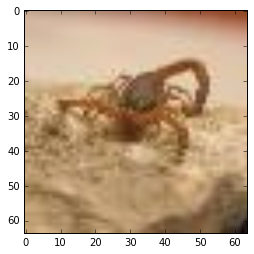

In [182]:
d = DictIterator(csv_location='train.csv')
gen = d.batch_gen()
gen.__next__()

In [240]:
from model_defs import *
from utils import *
import argparse
import pandas as pd
import os
import numpy as np
import csv
from keras.models import model_from_json




            

In [249]:
def try_modelx(csv_location='preprocessing/valset.csv',batch_size=64,mid='m1'):


    #define the batch generator   (validation set)
    val_datagen = CSVGenerator(csv_location=csv_location,
                                 batch_size=batch_size)

    val_generator = val_datagen.batch_gen()

    x = tf.placeholder(tf.float32, shape=(None, 64, 64, 3))

    # load json and create model
    json_file = open('models/'+mid+'.json', 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    model = model_from_json(loaded_model_json)
    # load weights into new model
    model.load_weights("models/"+mid+".h5")
    print("Loaded model from disk")

    d = val_generator.__next__()
    pred = model(x)
    pred
    # evaluate loaded model on test data
    #model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    #val_loss = model.evaluate_generator(
    #   generator = val_generator,
    #   val_samples = val_datagen.get_data_size())

    #print("%s: %.2f%%" % (model.metrics_names[1], val_loss[1]*100))
    #print(val_loss)

    pass

In [250]:
try_modelx()


10000
Loaded model from disk


In [252]:
import os
directory = '/dccstor/dlw/ambrish/examples/adversarial/models/m1'
if not os.path.exists(directory):
    os.makedirs(directory)

In [254]:
mid = 'm1'
epoch = 100
val_loss = [1.32,23.4]
with open('models/'+mid+'/acc_log.csv','a') as resultFile:
    r = np.concatenate([np.asarray([epoch]),val_loss])
    wr = csv.writer(resultFile,lineterminator='\n')
    
    wr.writerows([r])
    wr.writerow(['f','r','r'])